# DDC Final Project

By Ainur Yessenboldy, Madina Mamyrbekova, Shohruh Sadullaev

Instructions:
1. Download sattelite data for 15 tiles (15 tiles) that include all CA countries.
2. Put these files into one folder: either pre-{year} or eid-{year}.
3. Run this code.
4. CSV file and 2 png files will be generated at the end.

For your note, it takes around 30sec to run for one day (one folder).

### Install packages

In [85]:
# !pip install xarray netCDF4 matplotlib cartopy geopandas h5py glob2 rasterio astral hijridate zarr


In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import h5py
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
import numpy as np
from hijridate import Hijri, Gregorian

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Polygon
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
from affine import Affine


### Get control and focus dates using Hijri calendar

In [ ]:
years = []
for i in range(2012, 2025):
    gregorian_year = i
    hijri_year = Gregorian(gregorian_year, 1, 1).to_hijri().year

    # Ramadan is the 9th month in the Hijri calendar
    ramadan_start = Hijri(hijri_year, 8, 1).to_gregorian()

    # Try getting Ramadan 30, else fallback to Ramadan 29
    try:
        ramadan_end = Hijri(hijri_year, 9, 30).to_gregorian()
    except ValueError:
        ramadan_end = Hijri(hijri_year, 9, 29).to_gregorian()
        print(f"   * Note: Ramadan in {gregorian_year} had only 29 days.")

    years.append((ramadan_start, ramadan_end))
    print(f"{ramadan_start.strftime('%-d %B %Y')} - {ramadan_end.strftime('%-d %B %Y')}")

21 June 2012 - 18 August 2012
10 June 2013 - 7 August 2013
30 May 2014 - 27 July 2014
   * Note: Ramadan in 2015 had only 29 days.
19 May 2015 - 16 July 2015
8 May 2016 - 5 July 2016
   * Note: Ramadan in 2017 had only 29 days.
27 April 2017 - 24 June 2017
17 April 2018 - 14 June 2018
   * Note: Ramadan in 2019 had only 29 days.
6 April 2019 - 3 June 2019
25 March 2020 - 23 May 2020
14 March 2021 - 12 May 2021
4 March 2022 - 1 May 2022
   * Note: Ramadan in 2023 had only 29 days.
21 February 2023 - 20 April 2023
11 February 2024 - 9 April 2024


## VIIRS Visualization

Read the GeoJSON file

In [88]:
gdfs = []
for i in ['gadm/gadm41_UZB_1.json', 'gadm/gadm41_KAZ_1.json', 'gadm/gadm41_KGZ_1.json', 'gadm/gadm41_TJK_1.json', 'gadm/gadm41_TKM_1.json']:
    gdf = gpd.read_file(i)
    gdfs.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True)).to_crs(epsg=4326) 
gdf.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,UZB.1_1,UZB,Uzbekistan,Andijon,Andijan|Andizhan,NA,Wiloyat,Region,NA,UZ.AN,UZ-AN,"MULTIPOLYGON (((72.39200 40.40340, 72.37530 40..."
1,UZB.2_1,UZB,Uzbekistan,Buxoro,Bukhoro|Bukhara|Mawarranahr|Tran,NA,Wiloyat,Region,NA,UZ.BU,UZ-BU,"MULTIPOLYGON (((64.77820 39.76150, 64.79130 39..."
2,UZB.3_1,UZB,Uzbekistan,Farg'ona,Farghona|Fergana|Ferghana,NA,Wiloyat,Region,NA,UZ.FA,UZ-FA,"MULTIPOLYGON (((71.21100 39.93120, 71.21020 39..."
3,UZB.4_1,UZB,Uzbekistan,Jizzax,Dzhizak|Jizzakh,NA,Wiloyat,Region,NA,UZ.JI,UZ-JI,"MULTIPOLYGON (((67.75760 39.64240, 67.71370 39..."
4,UZB.8_1,UZB,Uzbekistan,Namangan,NA,NA,Wiloyat,Region,NA,UZ.NG,UZ-NG,"MULTIPOLYGON (((71.57710 40.81990, 71.56490 40..."


Select needed country or region:

gdf = combined_gdf[combined_gdf["COUNTRY"]=="Uzbekistan"].to_crs(epsg=4326)

gdf = combined_gdf[combined_gdf["HASC_1"]=="UZ.TK"].to_crs(epsg=4326)

<Axes: >

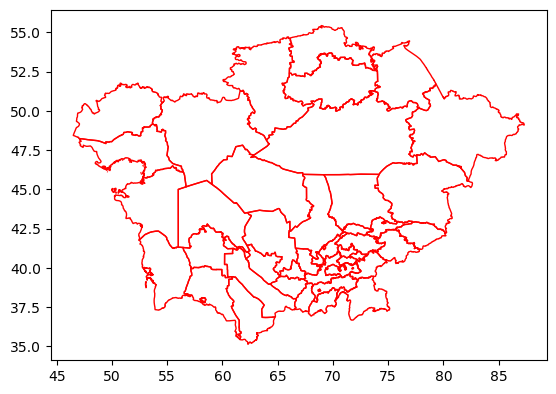

In [89]:
# Ensure the GeoDataFrame is in the same projection as Basemap
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1)

Path to VIIRS tiles

In [90]:
tile_folder = "eid-2014" # | pre-2014

In [ ]:
# Find all HDF5 files
tile_files = sorted(glob.glob(os.path.join(tile_folder, "*.h5")))

# Extract unique tile positions (hXX, vYY) and bounding coordinates
tile_positions = []
min_lon_global = float('inf')
max_lon_global = float('-inf')
min_lat_global = float('inf')
max_lat_global = float('-inf')

for file_path in tile_files:
    tile_name = os.path.basename(file_path)
    h_idx = int(tile_name.split('.')[2][1:3])  # Extract "hXX"
    v_idx = int(tile_name.split('.')[2][4:6])  # Extract "vYY"

    with h5py.File(file_path, 'r') as h5_file:
        # Read bounding coordinates from attributes
        vnp_group = h5_file['HDFEOS/GRIDS/VNP_Grid_DNB']
        min_lon = vnp_group.attrs['WestBoundingCoord'][0]
        max_lon = vnp_group.attrs['EastBoundingCoord'][0]
        min_lat = vnp_group.attrs['SouthBoundingCoord'][0]
        max_lat = vnp_group.attrs['NorthBoundingCoord'][0]

    tile_positions.append((h_idx, v_idx, tile_name, min_lon, max_lon, min_lat, max_lat))

    # Update global bounds
    min_lon_global = min(min_lon_global, min_lon)
    max_lon_global = max(max_lon_global, max_lon)
    min_lat_global = min(min_lat_global, min_lat)
    max_lat_global = max(max_lat_global, max_lat)

# Sort and get unique hXX (columns) and vYY (rows)
h_values = sorted(set([h for h, v, _, _, _, _, _ in tile_positions]))  # Unique horizontal indices
v_values = sorted(set([v for h, v, _, _, _, _, _ in tile_positions]))  # Unique vertical indices

# Compute the final image size
tile_size = 2400  # Each tile is 2400x2400 pixels
num_cols = len(h_values)  # Number of horizontal tiles
num_rows = len(v_values)  # Number of vertical tiles

final_width = num_cols * tile_size
final_height = num_rows * tile_size

print(f"Final image size: {final_width} × {final_height} pixels")  # Debugging

Final image size: 12000 × 7200 pixels


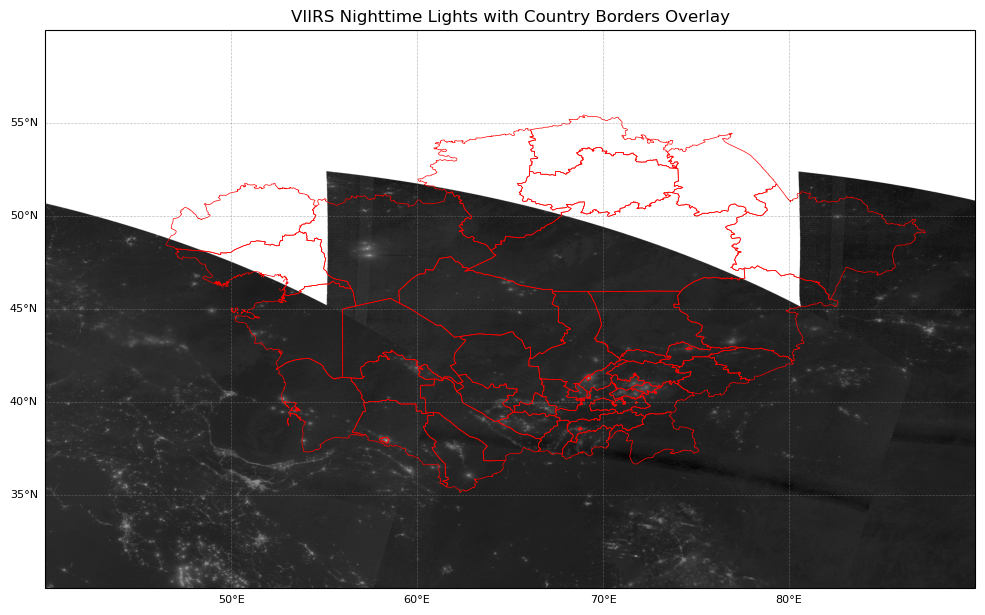

In [92]:
# Initialize empty array for the final image
final_image = np.full((final_height, final_width), np.nan, dtype=np.float32)

# Create mapping from tile indices to array positions
h_to_col = {h: i for i, h in enumerate(h_values)}
v_to_row = {v: i for i, v in enumerate(v_values)}

# Loop through each tile and place them in the correct position
for h_idx, v_idx, tile_name, min_lon, max_lon, min_lat, max_lat in tile_positions:
    with h5py.File(os.path.join(tile_folder, tile_name), 'r') as h5_file:
        dataset_path = "HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m"
        ntl_data = h5_file[dataset_path][()]

    # Compute row & col positions
    row_start = v_to_row[v_idx] * tile_size
    col_start = h_to_col[h_idx] * tile_size

    # Insert tile data into the final image
    final_image[row_start:row_start + tile_size, col_start:col_start + tile_size] = ntl_data

# Replace NaNs with 0
final_image = np.nan_to_num(final_image, nan=0)

# Apply log scaling for better visibility
final_image_log = np.log1p(final_image)

# Flip the image vertically
final_image_log = np.flipud(final_image_log)   # <----- CHANGED TO FLIPUD

# Create the map
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent of the map to the bounds of the tiles
ax.set_extent([min_lon_global, max_lon_global, min_lat_global, max_lat_global], crs=ccrs.PlateCarree())

gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)


# Plot the nighttime lights data on the map
ax.imshow(final_image_log, extent=[min_lon_global, max_lon_global, min_lat_global, max_lat_global],
          transform=ccrs.PlateCarree(), cmap='gray', origin='lower')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}


plt.title("VIIRS Nighttime Lights with Country Borders Overlay")
plt.savefig(tile_folder+"viirs_region.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Define the transformation (affine) from bounds of the image
transform = from_bounds(min_lon_global, min_lat_global, max_lon_global, max_lat_global, final_width, final_height)
final_image_log = np.flipud(final_image_log)   # <----- CHANGED TO FLIPUD

# Convert the geometries of the gdf to a mask
mask = geometry_mask(gdf.geometry, transform=transform, out_shape=final_image_log.shape)

# # Apply the mask to the image (keep only values inside gdf)
final_image_log_masked = np.ma.masked_array(final_image_log, mask=mask)
final_image_log_masked = np.rot90(final_image_log_masked, 2)
final_image_log_masked = np.fliplr(final_image_log_masked)

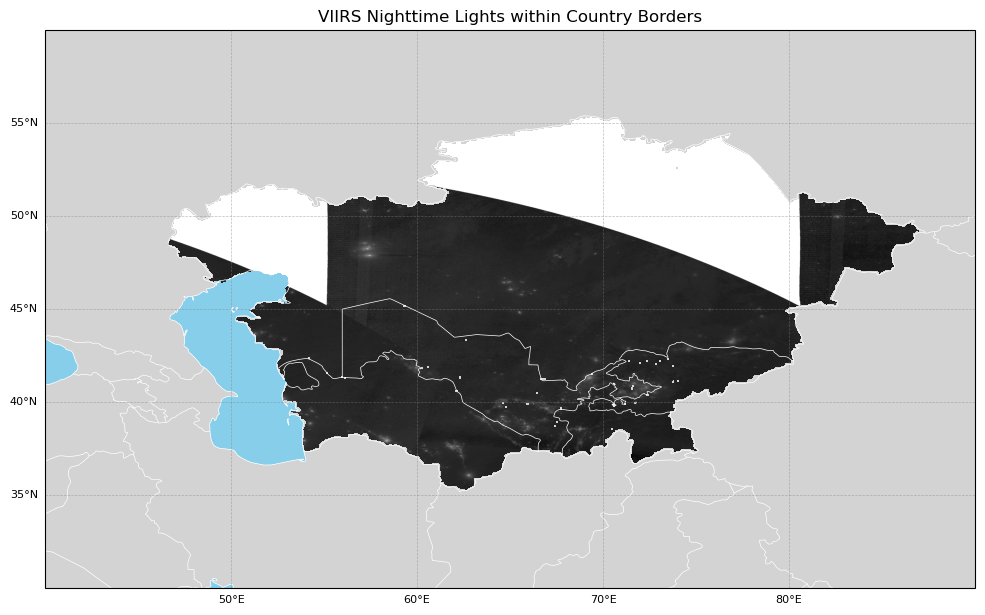

In [94]:
# Create the map
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent of the map to the bounds of the tiles
ax.set_extent([min_lon_global, max_lon_global, min_lat_global, max_lat_global], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='skyblue')

# Plot the masked nighttime lights data on the map
ax.imshow(final_image_log_masked, extent=[min_lon_global, max_lon_global, min_lat_global, max_lat_global],
          transform=ccrs.PlateCarree(), cmap='gray', origin='lower')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.title("VIIRS Nighttime Lights within Country Borders")
plt.savefig(tile_folder+"viirs_country.png", dpi=300, bbox_inches='tight')
plt.show()

In [95]:
def compute_radiance_sum(geometry):
    """Compute the radiance sum for a single geometry, ensuring it's iterable."""
    mask = geometry_mask([geometry], transform=transform, out_shape=final_image_log.shape)  # Wrap in list
    masked_image = np.ma.masked_array(final_image_log, mask=mask)
    return masked_image.sum()

# Apply function correctly using groupby
radiance = gdf
radiance["radiance"] = radiance["geometry"].apply(compute_radiance_sum)

In [96]:
gdf.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,radiance
0,UZB.1_1,UZB,Uzbekistan,Andijon,Andijan|Andizhan,NA,Wiloyat,Region,NA,UZ.AN,UZ-AN,"MULTIPOLYGON (((72.39200 40.40340, 72.37530 40...",80210.632812
1,UZB.2_1,UZB,Uzbekistan,Buxoro,Bukhoro|Bukhara|Mawarranahr|Tran,NA,Wiloyat,Region,NA,UZ.BU,UZ-BU,"MULTIPOLYGON (((64.77820 39.76150, 64.79130 39...",454281.781250
2,UZB.3_1,UZB,Uzbekistan,Farg'ona,Farghona|Fergana|Ferghana,NA,Wiloyat,Region,NA,UZ.FA,UZ-FA,"MULTIPOLYGON (((71.21100 39.93120, 71.21020 39...",100672.539062
3,UZB.4_1,UZB,Uzbekistan,Jizzax,Dzhizak|Jizzakh,NA,Wiloyat,Region,NA,UZ.JI,UZ-JI,"MULTIPOLYGON (((67.75760 39.64240, 67.71370 39...",230619.843750
4,UZB.8_1,UZB,Uzbekistan,Namangan,NA,NA,Wiloyat,Region,NA,UZ.NG,UZ-NG,"MULTIPOLYGON (((71.57710 40.81990, 71.56490 40...",105767.820312


In [97]:
gdf[["GID_1", "GID_0", "COUNTRY", "NAME_1", "ENGTYPE_1", "HASC_1", "ISO_1", "radiance"]].to_csv(tile_folder+'.csv')

## Visualization for Tajikistan

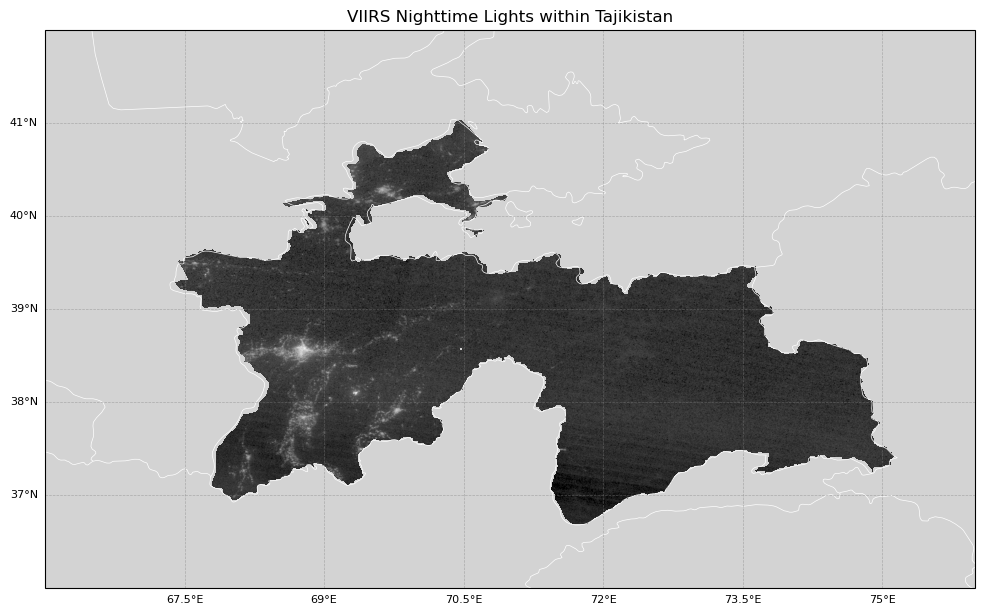

In [98]:
country_bbox = {
    "name": "Tajikistan",
    "min_lon": 66,  # replace with actual bounding box values
    "max_lon": 76,
    "min_lat": 36,
    "max_lat": 42
}

# Define the transformation (affine) from bounds of the image
# transform = from_bounds(min_lon_global, min_lat_global, max_lon_global, max_lat_global, final_width, final_height)
final_image_log = np.flipud(final_image_log)   # <----- CHANGED TO FLIPUD

taj_gdf=gdf[gdf["COUNTRY"]==country_bbox["name"]] 
# Convert the geometries of the gdf to a mask
mask = geometry_mask(taj_gdf.geometry, transform=transform, out_shape=final_image_log.shape)

# # Apply the mask to the image (keep only values inside gdf)
final_image_log_masked = np.ma.masked_array(final_image_log, mask=mask)
final_image_log_masked = np.rot90(final_image_log_masked, 2)
final_image_log_masked = np.fliplr(final_image_log_masked)
# Define the transformation (affine) from bounds of the image
# transform = from_bounds(min_lon_global, min_lat_global, max_lon_global, max_lat_global, final_width, final_height)
final_image_log = np.flipud(final_image_log)   # <----- CHANGED TO FLIPUD

taj_gdf=gdf[gdf["COUNTRY"]==country_bbox["name"]] 
# Convert the geometries of the gdf to a mask
mask = geometry_mask(taj_gdf.geometry, transform=transform, out_shape=final_image_log.shape)

# # Apply the mask to the image (keep only values inside gdf)
final_image_log_masked = np.ma.masked_array(final_image_log, mask=mask)
final_image_log_masked = np.rot90(final_image_log_masked, 2)
final_image_log_masked = np.fliplr(final_image_log_masked)


# Create the map
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent of the map to the bounds of the tiles
ax.set_extent([country_bbox["min_lon"], country_bbox["max_lon"], country_bbox["min_lat"], country_bbox["max_lat"]], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='skyblue')

# Plot the masked nighttime lights data on the map
ax.imshow(final_image_log_masked, extent=[min_lon_global, max_lon_global, min_lat_global, max_lat_global],
          transform=ccrs.PlateCarree(), cmap='gray', origin='lower')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.title("VIIRS Nighttime Lights within Tajikistan")
plt.savefig(tile_folder+"viirs_tajikistan.png", dpi=300, bbox_inches='tight')
plt.show()

## Calculate radiance deltas

In [ ]:
# Define file paths
path_control = r"data/pre-2024.csv"
path_treat = r"data/eid-2024.csv"

# Load both CSV files
df_control = pd.read_csv(path_control)
df_treat = pd.read_csv(path_treat)

# Select only relevant columns
columns_to_keep = ["COUNTRY", "NAME_1", "HASC_1", "radiance"]
df_control = df_control[columns_to_keep].rename(columns={"radiance": "radiance_control"})
df_treat = df_treat[columns_to_keep].rename(columns={"radiance": "radiance_treat"})

# Merge on COUNTRY, NAME_1, HASC_1
df_merged = pd.merge(df_control, df_treat, on=["COUNTRY", "NAME_1", "HASC_1"], how="inner")

# Calculate radiance_delta
df_merged["radiance_delta"] = (df_merged["radiance_treat"] - df_merged["radiance_control"]) / df_merged["radiance_control"] * 100

# Save to CSV
output_path = r"data/radiance_comparison_2024.csv"
df_merged.to_csv(output_path, index=False)

# Display first few rows
print(df_merged.head())

## Visualize deltas

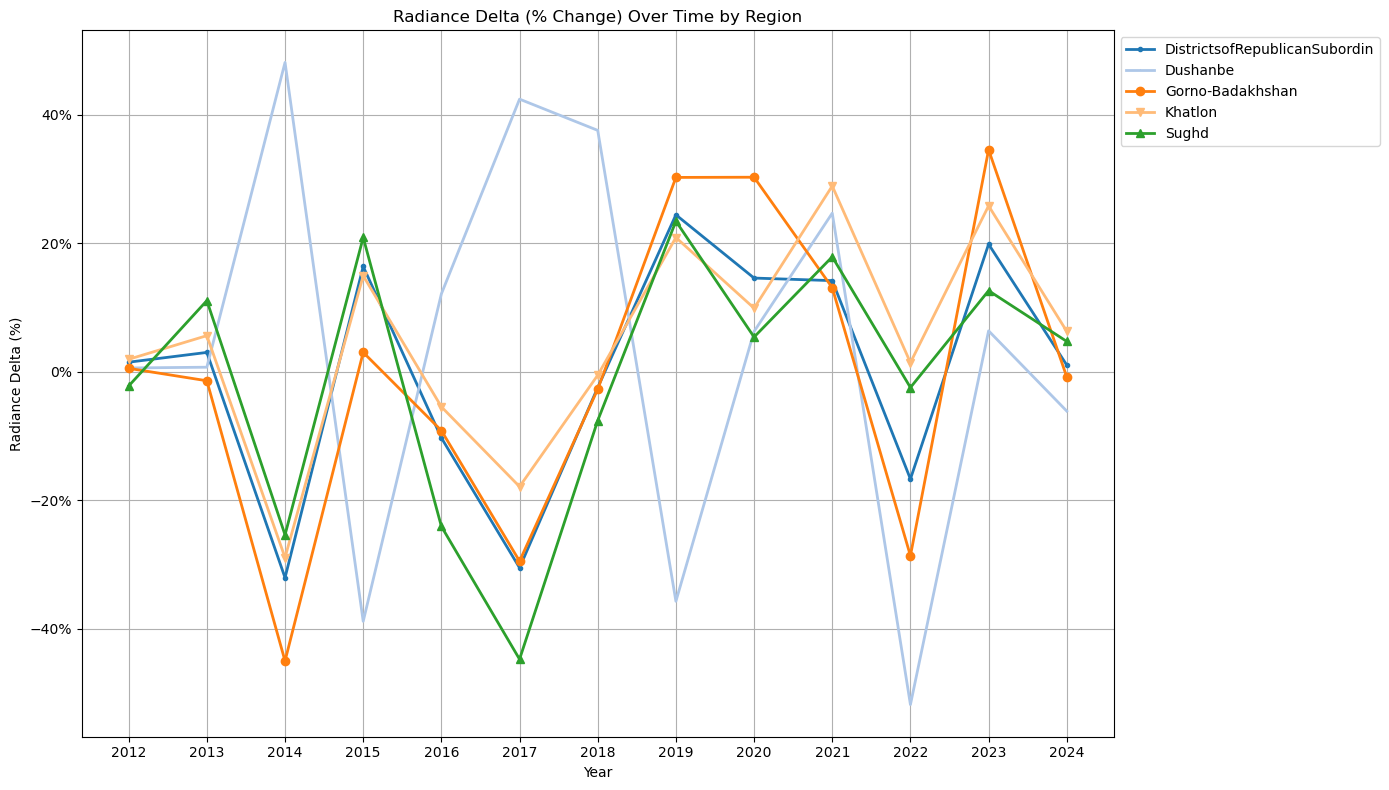

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.markers as mmarkers
from matplotlib.ticker import PercentFormatter

# Load data
df = pd.read_csv(r"data/radiance_comparison_updated.csv", sep=';')

# Clean radiance_delta column (and optionally others)
df["radiance_delta"] = (
    df["radiance_delta"]
    .str.replace(" ", "", regex=False)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Group by region and year
grouped = df.groupby(["NAME_1", "Year"])["radiance_delta"].mean().reset_index()

# Pivot for plotting
pivot_df = grouped.pivot(index="Year", columns="NAME_1", values="radiance_delta")

# Plot
plt.figure(figsize=(14, 8))
marker_styles = list(mmarkers.MarkerStyle.markers.keys())
colors = plt.cm.tab20.colors

for i, region in enumerate(pivot_df.columns):
    plt.plot(
        pivot_df.index,
        pivot_df[region] / 100,  # scale for percent axis
        label=region,
        marker=marker_styles[i % len(marker_styles)],
        color=colors[i % len(colors)],
        linewidth=2
    )

plt.title("Radiance Delta (% Change) Over Time by Region")
plt.xlabel("Year")
plt.ylabel("Radiance Delta (%)")
plt.xticks(pivot_df.index)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Visualize heatmaps 

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

geojson_path = r"gadm/gadm41_TJK_1.json"
radiance_csv_path = r"data/radiance_comparison_updated.csv"
output_folder = r"heatmaps/"
os.makedirs(output_folder, exist_ok=True)


gdf = gpd.read_file(geojson_path)
df_radiance = pd.read_csv(radiance_csv_path, sep=';')
df_radiance = pd.read_csv(radiance_csv_path, sep=';')

df_radiance["radiance_delta"] = df_radiance["radiance_delta"].str.replace(",", ".").astype(float)


# Compute global min/max for consistent color scale
vmin = df_radiance["radiance_delta"].min()
vmax = df_radiance["radiance_delta"].max()

# Loop through years and generate maps
for year in sorted(df_radiance["Year"].unique()):
    df_year = df_radiance[df_radiance["Year"] == year]
    gdf_year = gdf.merge(df_year[["HASC_1", "radiance_delta"]], on="HASC_1", how="left")

    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_year.plot(column="radiance_delta", 
                  cmap="plasma",
                  vmin=vmin, vmax=vmax,          
                  linewidth=0.8, 
                  edgecolor='black', 
                  legend=True,
                  legend_kwds={'label': "Radiance Δ", 'orientation': "vertical"},
                  ax=ax)

    ax.set_title(f"Radiance Change per Region in Tajikistan - {year}", fontsize=14)
    ax.axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"tajikistan_radiance_{year}.png"), dpi=300)
    plt.close()

print("All maps saved with consistent color scale.")

All maps saved with consistent color scale.
